In [3]:
import numpy as np
import copy 
import time
import random
import math

In [4]:
def str_arr(arr):
    strng = ""
    for obj in arr: 
        if type(obj) is type(""):
            strng += obj + " "   
        else:
            strng += "%.5f" % obj + " "
    return strng

In [5]:
def to_numpy_versions(nodes, edges):
    # In edge weights.
    N = np.array([edges[n][0][1] for n in nodes], dtype=np.float32)
    S = np.array([1 for n in nodes], dtype=np.float32)
    
    # Adjacency Matrix
    M = []
    for n in nodes:
        column = [0 for _ in range(len(nodes))]
        for e in edges[n]:
            if e[0] != n:
                column[nodes.index(e[0])] = e[1]
        M.append(column)
    M = np.transpose(np.array(M, dtype=np.float32))
    
    return N,M,S
    

def matrix_approximation(steps, nodes, edges):
    # NOTE(const): This is a python template for the Bittensor EOS contract. It is written to approximate the
    # Matrix multiplication emission system from above but using serial transactions which distribute the execution 
    # cost across all the network nodes.
    
    N,M,S = to_numpy_versions(nodes, edges)
    
    print ('Initial stake: ', S)
    print ('Loop weights: ', N)
    print ('Adjacency matrix: ', M)
    
    for step in range(steps):        
        # Attribution calculation.
        A = np.multiply(S, N)
        T = np.matmul(M, S)
        for _ in range(100):
            A += np.multiply(T, N)
            T = np.matmul(M, T)
        A = A / np.linalg.norm(A, 1)
        
        # Emission Calculation
        E = A * 50
        S = S + E
        
    # Return final attributions.
    return list(A)


In [6]:
import copy
class Bittensor:
    # NOTE(const): This is a python template for the Bittensor EOS contract. It is written to approximate the
    # Matrix multiplication emission system from above but using serial transactions which distribute the execution 
    # cost across all the network nodes.
    
    def __init__(self): 
        self.edges = {} # id --> edges.
        self.emit_height = {} # id --> last emit block.
        self.block_height = 0 # chain height.
        
        self.stake = {} # id --> stake
        self.next_stake = {} # temporary version of self.stake (only for testing.)
        self.total_stake = 0 # total supply of staked token.
        self.next_total_stake = 0 # temporary version of self.total_supply (only for testing.)
        
        self.throughput = {} # id --> throughput
        self.next_throughput = {} # temporary version of self.stake (only for testing.)
        self.total_throughput = 0 # total supply of staked token.
        self.next_total_throughput = 0 # temporary version of self.total_supply (only for testing.)
        
        
    def subscribe(self, this_identity):
        # NOTE(const): Subscribing a neuron to the metagraph will involve locking token funds in the main EOS contract
        # and shifting them into the metagraph to act as stake. The token contract is thus two tokens, one which acts 
        # like a normal EOS token, it can be transfered easily, and tokens which act as stake within the metagraph.
        # When a node "unsubscribes" the stake that has been gained through metagraph emission is transfered back to the
        # participants account on EOS.
        
        # TODO(const): It is not yet obvious if tokens that are held out of the metagraph should be attaining emission.
        # If they are not, then it seems like people are likely to hold their tokens in the metagraph without running a 
        # neuron. This will clutter the graph. It would be better if only participants were offered the opportunity to attain
        # mining emissions.
        self.next_total_stake += 1        
        self.next_stake[this_identity] = 1
        
        self.next_total_throughput += 1        
        self.next_throughput[this_identity] = 1
        
        self.edges[this_identity] = [(this_identity, 1.0)]
        self.emit_height[this_identity] = self.block_height
        
    def inc_height(self):
        # Note(const): This function will not be included in the EOS contract. This is used to keep all the nodes in lockstep,
        # a.k.a at the same height and using the same denominator in ( self.stake[id] / self.total_stake).
        # In reality these will differ and it will give nodes an advantage if they are able to call the emit function
        # before the total_stake term is incremented by their competitors. This should give the network incentive 
        # to continually emit tokens (remember that this is costly for the calling node.)
        self.stake = copy.deepcopy(self.next_stake)
        self.total_stake = self.next_total_stake
        self.throughput = copy.deepcopy(self.next_throughput)        
        self.total_throughput = self.next_total_throughput
        
        self.block_height += 1
        
    def emit(self, this_identity, edges):
        # NOTE(const): We are wrapping the emission function with the update attribution function. 
        # This can be done because we require an emission call BEFORE a node changes his edge set in the graph.
        # hence they are essentially the same call.
                
        # Edge set checks.
        assert(edges[0][0] == this_identity)
        assert(abs(sum([w for i, w in edges]) - 1.0) < 0.001 )

        # Get emission and apply it.
        this_emission = self._get_emission(this_identity)
        self._do_emit(this_identity, this_emission)

        # Update to the new edge set.
        self.edges[this_identity] = edges
        self.emit_height[this_identity] = self.block_height
        

    # Bitcoin (esque) emission.
    def _get_emission(self, this_identity):
        
        # NOTE(const): Emit rate governs the average number of tokens to emit after each EOS block.
        # In the future, this amount should change with block height to model an emission decay
        # as is the case with Bitcoin.
        EMIT_RATE = 50              
        
        # The time since my last token emit. 
        # Note that if emit rate changes in time, that this calculation will need to be changed.
        delta_blocks = self.block_height - self.emit_height[this_identity]    
        
        # NOTE(const): The reinforcement term governs the effect of stake on the output. 
        # Removing this term makes all nodes equal. Dampening it with a logarithm will
        # decrease the effect of having a higher ratio of the total stake.
        stake_reinforcement = (self.stake[this_identity] / self.total_stake) 
        
        # NOTE(const): The emission term here is built to distribute rewards evenly across nodes
        # in proportion to their attribution in the graph (as well as a reflection of their stake holdings)
        this_emission = EMIT_RATE * delta_blocks * stake_reinforcement
        
        return this_emission
               
    def _do_emit(self, this_identity, this_emission):
        # NOTE(const): The _do_emit function is the most computationally expensive call within the contract. 
        # It involves a depth first recursion which terminates when the emission total has been exhausted. 
        # In the worst case this function's runtime is O(DELTA_BLOCKS * EMIT_RATE * (1 / MIN_INCREMENT))
        # The function is paid by the calling node which will require that node holds enough EOS to make the call.
        # TODO(const): I am uncertain of the EOS token requirements this function requires, or what happens whena 
        # a callee cannot afford the transaction.
        MIN_INCREMENT = 0.00001
              
        # Recurse the emmision through the tree.
        emission_queue = [(this_identity, this_emission)]
        while len(emission_queue) > 0:
            
            # Next.
            current_identity, current_emission = emission_queue.pop()
            current_inedge = self.edges[current_identity][0][1]
                        
            # NOTE(const): Update global vars for next step. In reality these will be updated immediately.
            # For testing purposes we hold them locked until every node has updated.
            self.next_stake[current_identity] += (current_emission * current_inedge) 
            self.next_total_stake += (current_emission * current_inedge)
            
            self.next_throughput[current_identity] += (current_emission if current_identity != this_identity else 0)
            self.next_total_throughput += (current_emission if current_identity != this_identity else 0)
            
            # Recurse.
            for next_identity, next_weight in self.edges[current_identity][1:]:
                next_emission = current_emission * next_weight                
                if next_emission > MIN_INCREMENT:
                    emission_queue.append((next_identity, current_emission * next_weight)) 
                                   
        
    def __str__(self):
        strng = "" 
        strng += "S: " + str_arr([self.stake[identity] for identity in self.stake.keys()]) + "\n" 
        return strng

In [8]:

# Metagraph description. Edge weights reflect attribution scores.
nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
edges = {'a': list(zip(['a', 'b', 'c', 'd'], [0.6, 0.1, 0.1, 0.2])),
         'b': list(zip(['b'], [1.0])),
         'c': list(zip(['c', 'a', 'd'], [0.4, 0.3, 0.3])),
         'd': list(zip(['d', 'a', 'b', 'c'], [0.5, 0.2, 0.1, 0.2])),
         'e': list(zip(['e', 'f'], [0.5, 0.5])),
         'f': list(zip(['f', 'e'], [0.5, 0.5])),
         'g': list(zip(['g'], [1.0])),
         'h': list(zip(['h'], [1.0])),
         'i': list(zip(['i'], [1.0])),
         'j': list(zip(['j'], [1.0]))
}

# Number of EOS transactions blocks. 
blocks = 100

# Trial statistic storage: {id} --> ([block num], [stake])
data = {}
for n in nodes:
    data[n] = ([0],[1])
data['total'] = ([0],[len(nodes)])    


# Init Bittensor contract and subscribe each node to the metagraph.
b = Bittensor()
for k in nodes:
    b.subscribe(k)
b.inc_height()


# Simulation main loop.
for i in range(blocks):        
    for k in nodes:
        b.emit(k, edges[k])
        data[k][1].append(b.stake[k])
        data[k][0].append(b.block_height)
    data['total'][1].append(b.total_stake)
    data['total'][0].append(b.block_height)
    b.inc_height()

    
# Plot results.
import matplotlib.pyplot as plt

# plot total stake.
plt.figure(figsize=(10,8))
plt.title('Stake Total', fontsize=20)
plt.xlabel('block height', fontsize=15)
plt.ylabel('stake', fontsize=15)
for k in nodes:
    plt.plot(data[k][0], data[k][1])      
plt.plot(data['total'][0], data['total'][1])

# plot stake fraction.
plt.figure(figsize=(10,8))
plt.title('Stake Fraction', fontsize=20)
plt.xlabel('block height', fontsize=15)
plt.ylabel('fraction', fontsize=15)
for k in nodes:
    plt.plot(data[k][0], [a/b for a,b in list(zip(data[k][1], data['total'][1]))])

print ('Matrix Attributions:', str_arr(matrix_approximation(blocks, nodes, edges)))
print ('Totals:', str_arr([data[k][1][-1] for k in nodes]))
print ('Trial Attributions:', str_arr([data[k][1][-1]/data['total'][1][-1] for k in nodes]))



    

Initial stake:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Loop weights:  [0.6 1.  0.4 0.5 0.5 0.5 1.  1.  1.  1. ]
Adjacency matrix:  [[0.  0.  0.3 0.2 0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.2 0.  0.  0.  0.  0.  0. ]
 [0.2 0.  0.3 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
Matrix Attributions: 0.06778 0.26191 0.02309 0.04722 0.10000 0.10000 0.10000 0.10000 0.10000 0.10000 
Totals: 417.42101 1099.55391 161.24386 303.77951 496.22009 496.22009 496.22393 496.22393 496.22393 496.22393 
Trial Attributions: 0.08417 0.22171 0.03251 0.06125 0.10006 0.10006 0.10006 0.10006 0.10006 0.10006 


In [52]:
import copy
class BittensorThresholded:
    # NOTE(const): This is a python template for the Bittensor EOS contract. It is written to approximate the
    # Matrix multiplication emission system from above but using serial transactions which distribute the execution 
    # cost across all the network nodes.
    
    def __init__(self): 

        self.edges = {} # id --> edges.
        self.emit_height = {} # id --> last emit block.

        self.block_height = 0 # chain height.
        self.stake = {} # id --> stake
        self.total_stake = 0 # total supply of staked token.

        self.attribution = {} # temporary version of self.stake (only for testing.)
     
        
    def subscribe(self, this_identity):
        # NOTE(const): Subscribing a neuron to the metagraph will involve locking token funds in the main EOS contract
        # and shifting them into the metagraph to act as stake. The token contract is thus two tokens, one which acts 
        # like a normal EOS token, it can be transfered easily, and tokens which act as stake within the metagraph.
        # When a node "unsubscribes" the stake that has been gained through metagraph emission is transfered back to the
        # participants account on EOS.
        
        # TODO(const): It is not yet obvious if tokens that are held out of the metagraph should be attaining emission.
        # If they are not, then it seems like people are likely to hold their tokens in the metagraph without running a 
        # neuron. This will clutter the graph. It would be better if only participants were offered the opportunity to attain
        # mining emissions.
        self.total_stake += 1        
        self.stake[this_identity] = 1
        self.attribution[this_identity] = 0
                
        self.edges[this_identity] = [(this_identity, 1.0)]
        self.emit_height[this_identity] = self.block_height
        
    def inc_height(self):
        # Note(const): This function will not be included in the EOS contract. This is used to keep all the nodes in lockstep,
        # a.k.a at the same height and using the same denominator in ( self.stake[id] / self.total_stake).
        # In reality these will differ and it will give nodes an advantage if they are able to call the emit function
        # before the total_stake term is incremented by their competitors. This should give the network incentive 
        # to continually emit tokens (remember that this is costly for the calling node.)
        
        max_attr = -math.inf
        min_attr = math.inf
        for attr in self.attribution.values():
            max_attr = max(attr, max_attr)
            min_attr = min(attr, min_attr)
                    
        total_attribution = max(1, sum([attr for attr in self.attribution.values()]))        
        sigmoid_attributions = {} 
        for idn in self.attribution.keys():
            attr = self.attribution[idn]
            normed_attr = (attr - min_attr) / max(1, (max_attr - min_attr)) # onto range 0 1
            shifted_attr = normed_attr - 0.5 # onto range -0.5 +0.5
            sigmoid_attr = 1/(1 + math.exp(-shifted_attr))
            self.stake[idn] += sigmoid_attr
            self.total_stake += sigmoid_attr
            self.attribution[idn] = 0
            print ('id:', idn, "att:", attr, ' na:', normed_attr, " sa:", shifted_attr, " sga:", sigmoid_attr)
            
        self.block_height += 1
        
    def emit(self, this_identity, edges):
        # NOTE(const): We are wrapping the emission function with the update attribution function. 
        # This can be done because we require an emission call BEFORE a node changes his edge set in the graph.
        # hence they are essentially the same call.
                
        # Edge set checks.
        assert(edges[0][0] == this_identity)
        assert(abs(sum([w for i, w in edges]) - 1.0) < 0.001 )

        # Get emission and apply it.
        this_emission = self._get_emission(this_identity)
        self._do_emit(this_identity, this_emission)

        # Update to the new edge set.
        self.edges[this_identity] = edges
        self.emit_height[this_identity] = self.block_height
        

    # Bitcoin (esque) emission.
    def _get_emission(self, this_identity):
        
        # NOTE(const): Emit rate governs the average number of tokens to emit after each EOS block.
        # In the future, this amount should change with block height to model an emission decay
        # as is the case with Bitcoin.
        EMIT_RATE = 50              
        
        # The time since my last token emit. 
        # Note that if emit rate changes in time, that this calculation will need to be changed.
        delta_blocks = self.block_height - self.emit_height[this_identity]    
        
        # NOTE(const): The reinforcement term governs the effect of stake on the output. 
        # Removing this term makes all nodes equal. Dampening it with a logarithm will
        # decrease the effect of having a higher ratio of the total stake.
        stake_reinforcement = (self.stake[this_identity] / self.total_stake) 
        
        # NOTE(const): The emission term here is built to distribute rewards evenly across nodes
        # in proportion to their attribution in the graph (as well as a reflection of their stake holdings)
        this_emission = EMIT_RATE * delta_blocks * stake_reinforcement
        
        return this_emission
               
    def _do_emit(self, this_identity, this_emission):
        # NOTE(const): The _do_emit function is the most computationally expensive call within the contract. 
        # It involves a depth first recursion which terminates when the emission total has been exhausted. 
        # In the worst case this function's runtime is O(DELTA_BLOCKS * EMIT_RATE * (1 / MIN_INCREMENT))
        # The function is paid by the calling node which will require that node holds enough EOS to make the call.
        # TODO(const): I am uncertain of the EOS token requirements this function requires, or what happens whena 
        # a callee cannot afford the transaction.
        MIN_INCREMENT = 0.00001
              
        # Recurse the emmision through the tree.
        emission_queue = [(this_identity, this_emission)]
        while len(emission_queue) > 0:
            
            # Next.
            current_identity, current_emission = emission_queue.pop()
            current_inedge = self.edges[current_identity][0][1]
                        
            # Summing attribution scores at the nodes along this emission route.
            self.attribution[current_identity] += (current_emission * current_inedge) 
            
            # Recurse.
            for next_identity, next_weight in self.edges[current_identity][1:]:
                next_emission = current_emission * next_weight                
                if next_emission > MIN_INCREMENT:
                    emission_queue.append((next_identity, current_emission * next_weight)) 
                                   
        
    def __str__(self):
        strng = "" 
        strng += "S: " + str_arr([self.stake[identity] for identity in self.stake.keys()]) + "\n" 
        return strng

id: a att: 0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: b att: 0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: c att: 0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: d att: 0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: e att: 0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: f att: 0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: g att: 0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: h att: 0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: i att: 0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: j att: 0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: a att: 5.0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: b att: 5.0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: c att: 5.0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: d att: 5.0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: e att: 5.0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: f att: 5.0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: g att: 5.0  na: 0.0  sa: -0.5  sga: 0.3775406687981454
id: h att: 5.0  n

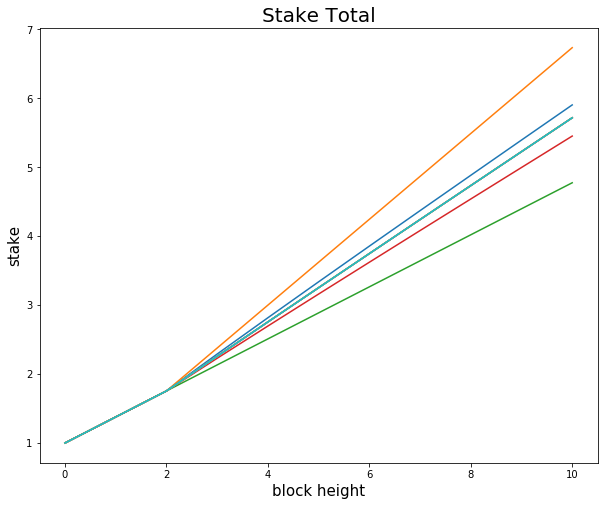

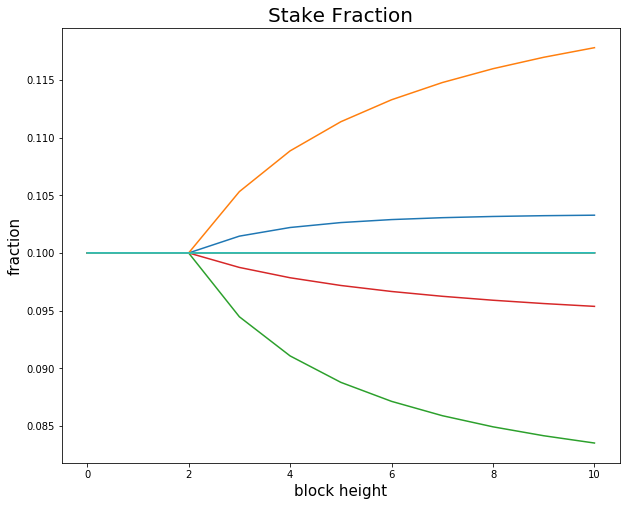

In [53]:
# Metagraph description. Edge weights reflect attribution scores.
nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
edges = {'a': list(zip(['a', 'b', 'c', 'd'], [0.6, 0.1, 0.1, 0.2])),
         'b': list(zip(['b'], [1.0])),
         'c': list(zip(['c', 'a', 'd'], [0.4, 0.3, 0.3])),
         'd': list(zip(['d', 'a', 'b', 'c'], [0.5, 0.2, 0.1, 0.2])),
         'e': list(zip(['e', 'f'], [0.5, 0.5])),
         'f': list(zip(['f', 'e'], [0.5, 0.5])),
         'g': list(zip(['g'], [1.0])),
         'h': list(zip(['h'], [1.0])),
         'i': list(zip(['i'], [1.0])),
         'j': list(zip(['j'], [1.0]))
}

# Number of EOS transactions blocks. 
blocks = 10

# Trial statistic storage: {id} --> ([block num], [stake])
data = {}
for n in nodes:
    data[n] = ([0],[1])
data['total'] = ([0],[len(nodes)])    


# Init Bittensor contract and subscribe each node to the metagraph.
b = BittensorThresholded()
for k in nodes:
    b.subscribe(k)
b.inc_height()


# Simulation main loop.
for i in range(blocks):        
    for k in nodes:
        b.emit(k, edges[k])
        data[k][1].append(b.stake[k])
        data[k][0].append(b.block_height)
    data['total'][1].append(b.total_stake)
    data['total'][0].append(b.block_height)
    b.inc_height()

    
# Plot results.
import matplotlib.pyplot as plt

# plot total stake.
plt.figure(figsize=(10,8))
plt.title('Stake Total', fontsize=20)
plt.xlabel('block height', fontsize=15)
plt.ylabel('stake', fontsize=15)
for k in nodes:
    plt.plot(data[k][0], data[k][1])      
#plt.plot(data['total'][0], data['total'][1])

# plot stake fraction.
plt.figure(figsize=(10,8))
plt.title('Stake Fraction', fontsize=20)
plt.xlabel('block height', fontsize=15)
plt.ylabel('fraction', fontsize=15)
for k in nodes:
    plt.plot(data[k][0], [a/b for a,b in list(zip(data[k][1], data['total'][1]))])

print ('Matrix Attributions:', str_arr(matrix_approximation(blocks, nodes, edges)))
print ('Totals:', str_arr([data[k][1][-1] for k in nodes]))
print ('Trial Attributions:', str_arr([data[k][1][-1]/data['total'][1][-1] for k in nodes]))


